# Projet

### Imports

In [ ]:
# Imports
import glob, os
import pandas
import urllib
from SPARQLWrapper import SPARQLWrapper
import PIL.Image
from skimage import io
import ipywidgets
import matplotlib.pyplot as plt
import numpy
from sklearn.cluster import KMeans
from random import randint

### WikiBaseIntegrator Imports

In [ ]:
from wikibaseintegrator import WikibaseIntegrator
from wikibaseintegrator.wbi_config import config

config['USER_AGENT'] = 'test'

## 1. Collecte de données

### Dataframe Functions

In [ ]:
def getData(): # Prends les données au format JSON pour en faire une dataframe
    path = "data.json"
    with open(path, "r", encoding="utf-8") as f:
        dataframe = pandas.read_json(f, orient='index')
    return dataframe

def saveData(dataframe): # Enregistre la dataframe au format JSON
    path = "data.json"
    with open(path, "w", encoding="utf-8") as f:
        f.write(dataframe.to_json(orient='index', indent=2))

def getUsers(): 
    path = "users.json"
    with open(path, "r", encoding="utf-8") as f:
        dataframe = pandas.read_json(f, orient='index')
    return dataframe

def saveUsers(dataframe):   
    path = "users.json"
    with open(path, "w", encoding="utf-8") as f:
        f.write(dataframe.to_json(orient='index', indent=2))

### WikiBaseIntegrator Functions

In [ ]:
wbi = WikibaseIntegrator()

def GetCountryLabelInFrench(itemID): #Permet de récupérer le label du pays en français à partir de son qualifier/ID WikiData
    item_data=wbi.item.get(itemID) #Récupère les données du monument
    country_id=item_data.claims.get('P17')[0].mainsnak.datavalue['value']['id'] #Récupère l'ID du pays
    country=wbi.item.get(country_id) #Récupère les données du pays
    return country.labels.get('fr').value #Retourne le label du pays en français

def AddCountryTags(dataframe): #Permet d'ajouter le tag du pays à chaque ligne du dataframe
    items_tuples=[]
    for i in range(len(dataframe.index)): # Récupère les IDs de toutes les lignes du dataframe
        itemID=dataframe._get_value(i,"entityID")
        items_tuples.append(itemID)
    for i in range(len(items_tuples)): # Ajoute le pays à chaque ligne du dataframe
        country = GetCountryLabelInFrench(items_tuples[i])
        dataframe.at[i, "tags"].append("#"+country)
    return dataframe

def GetArchitecturalStyle(styleID): #Permet de récupérer le nom du style architectural en français à partir de son qualifier/ID WikiData
    styleL=[]
    for i in range(len(styleID)): # Récupère les IDs de style architectural pour chaque ligne du dataframe
        style = wbi.item.get(styleID[i]) #Récupère les données du style architectural
        if style.labels.get('fr') is None: #Prise en charge du cas où le style n'a pas de nom en français
            style_name = style.labels.get('en').value
        else:
            style_name = style.labels.get('fr').value
        styleL.append("#"+style_name) #Ajoute le nom du style à la liste de résultat
    return styleL #Retourne le nom du style architectural

def AddStyleTags(dataframe): #Permet d'ajouter les tags des styles architecturaux à chaque ligne du dataframe
    for k in range(len(dataframe.index)): #On parcourt chaque ligne du dataframe
        style = GetArchitecturalStyle(dataframe._get_value(k,"style"))
        for l in range(len(style)): #On parcourt chaque indice de la liste de style (un monument peut avoir plusieurs styles)
            dataframe.at[k, "tags"].append(style[l])
    return dataframe

### Récupération du résultat d'une query Wikidata

In [ ]:
size = 20
imagesPath = "./images/"

# Query de Wikidata
sparql = SPARQLWrapper("https://query.wikidata.org/sparql")
query = """
SELECT ?item ?itemLabel ?pic (YEAR(?date) as ?year) ?style WHERE {
  ?item wdt:P31 wd:Q4989906;
    wdt:P18 ?pic;
    wdt:P571 ?date;
    wdt:P149 ?style.
  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
}
LIMIT """
# On précise le nombre d'entrées que l'on veut
query = query + str(size)

# On récupère le résultat de la query
sparql.setQuery(query)
sparql.setReturnFormat("json")
results = sparql.query().convert()
print(results)

# On normalise les résultats pour pandas
array = []
for trainData in results["results"]["bindings"]:
    name = trainData["itemLabel"]["value"]
    format = trainData["pic"]["value"].split(".")[-1]
    path = f"{imagesPath}{name}.{format}"
    if "year" in trainData.keys():
        year = trainData["year"]["value"]
    else:
        year = None
    style = trainData["style"]["value"]
    array.append([name,  
                  trainData["pic"]["value"], 
                  trainData["item"]["value"].split(sep='/')[-1],
                  format,
                  path,
                  (),
                  None,
                  ['#monument'],
                  year,
                  style.split(sep='/')[-1]])
                  

dataframe = pandas.DataFrame(array, columns=["label", "link", "entityID", "format", "path", "size", "sizeCategory", "tags", "year","style"])

#On fusionne les lignes avec le même label en gardant les différents styles
dataframe = dataframe.groupby('label').agg({'link':'first', 'entityID':'first', 'format':'first', 'path':'first', 'size':'first', 'sizeCategory':'first','tags':'first', 'year':'first', 'style':list}).reset_index()

# On enregistre les données au format JSON
saveData(dataframe)

# Nettoyage du dossier /images
if not os.path.isdir('./images'):
  os.mkdir('./images')

# Nettoyage du dossier /images
else:
  files = glob.glob('./images/*')
  for f in files:
      os.remove(f)

dataframe

### Téléchargement des Images

In [ ]:
dataframe = getData()
for i in range(len(dataframe.index)):
    # On télécharge l'image
    link = dataframe._get_value(i,"link")
    path = dataframe._get_value(i,"path")
    response = urllib.request.urlretrieve(link, path)


 
img = io.imread(path)
io.imshow(img)

### Récupération des Données EXIFS

In [ ]:
dataframe = getData()

wantedExifs = [274, 315, 306, 272]
columnNames = ["orientation", "artist", "dateTaken", 'appareil']

for i,tag in enumerate(wantedExifs):
    dataframe[columnNames[i]] = None
    

# On parcourt les entrées
for i in range(len(dataframe.index)):
    path = dataframe._get_value(i,"path")
    img = PIL.Image.open(path)
    exif_data = img._getexif()
    img.close()

    dataframe.at[i, "size"] = img.size
    if img.size[0] < img.size[1]:
        dataframe.at[i, "orientation"] = 0
    else:
        dataframe.at[i, "orientation"] = 1

    if exif_data:
      for tag in exif_data:
            if tag in wantedExifs:
                dataframe.at[i, columnNames[wantedExifs.index(tag)]] = exif_data[tag]
                
dataframe.astype({'orientation': 'int32'})

# On enregistre les données au format JSON
saveData(dataframe)
        
dataframe 


## 2. Annotation des images

### Fonction pour récupérer et ajouter le tag siècle

In [ ]:
def find_century(year): #Permet de trouver le siècle à partir de l'année
    year = int(year)
    if (year <= 0): 
        cent_tag=("#Antiquité")
    elif (year <= 100):
        cent_tag ="#1er siècle"
    elif (year % 100 == 0):
        cent_tag="#"+str(year // 100)+"ème siècle"
    else:
        cent_tag="#"+str(year // 100 + 1)+"ème siècle"
    return cent_tag

def add_century_tag(dataframe): #Permet d'ajouter le tag siècle à chaque ligne du dataframe
    for i in range(len(dataframe.index)):
        year = dataframe._get_value(i,"year")
        if year is not None: #Prise en charge du cas où le monument n'a pas de date précise de construction
            dataframe.at[i, "tags"].append(find_century(year))
        else:
            dataframe.at[i, "tags"].append("#Inconnu")
    return dataframe

### Test Ajout du tag siècle

In [ ]:
add_century_tag(dataframe)

### Test Ajout des tags country et style

In [ ]:
AddCountryTags(dataframe)

In [ ]:
AddStyleTags(dataframe)

## Analyse des Données

### Kmeans et Couleurs dominantes

In [57]:
dataframe = getData()
dataframe["dColors"] = None
dataframe["dProportions"] = None

nColors = 6
laziness = 100

kmeans = KMeans(n_clusters=nColors, random_state=0, n_init="auto")


for i, path in enumerate(dataframe["path"]):
    img = PIL.Image.open(path).convert('RGB')
    pixelData = numpy.array(img).reshape(-1, 3)[::laziness]
    kmeans.fit(pixelData)

    proportions = numpy.array([0 for i in range(nColors)])
    for x in kmeans.labels_:
        proportions[x] += numpy.float64(1)
    proportions = proportions / kmeans.labels_.size

    dataframe.at[i,"dColors"] = numpy.int32(kmeans.cluster_centers_)
    dataframe.at[i,"dProportions"] = proportions
    
saveData(dataframe)

dataframe

C:\Users\tomgr\Documents\Dev\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\tomgr\Documents\Dev\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


,label,link,entityID,format,path,size,sizeCategory,tags,year,style,orientation,artist,dateTaken,appareil,dColors,dProportions
0,Basilica of Saint Mary of the Chorus,http://commons.wikimedia.org/wiki/Special:File...,Q2842138,jpg,./images/Basilica of Saint Mary of the Chorus.jpg,"[3634, 4614]",NaN,"[#monument, #18ème siècle, #Espagne, #architec...",1774.0,[Q840829],0,None,None,None,"[[112, 97, 73], [203, 194, 165], [136, 183, 24...","[0.2536365425560466, 0.1391637294018715, 0.151..."
1,"Basilica of Santa María, Portugalete",http://commons.wikimedia.org/wiki/Special:File...,Q2835988,jpg,"./images/Basilica of Santa María, Portugalete.jpg","[2592, 1944]",NaN,"[#monument, #15ème siècle, #Espagne, #architec...",1480.0,"[Q176483, Q236122]",1,None,2006:06:23 11:59:52,Canon PowerShot G5,"[[87, 140, 214], [19, 23, 21], [118, 111, 105]...","[0.35950306614538885, 0.1630713052451924, 0.11..."
2,Casa de los Botines,http://commons.wikimedia.org/wiki/Special:File...,Q2547508,JPG,./images/Casa de los Botines.JPG,"[3456, 2304]",NaN,"[#monument, #19ème siècle, #Espagne, #style né...",1892.0,[Q186363],1,None,2006:08:31 19:09:34,Canon EOS 350D DIGITAL,"[[45, 48, 48], [214, 244, 250], [131, 133, 133...","[0.14847978700691977, 0.12736885729714795, 0.1..."
3,Castillo de Belmonte,http://commons.wikimedia.org/wiki/Special:File...,Q917896,jpg,./images/Castillo de Belmonte.jpg,"[1000, 667]",NaN,"[#monument, #15ème siècle, #Espagne, #art mudé...",1456.0,[Q15011985],1,Photographer: Pol Mayer,2011:11:18 18:56:12,Canon EOS 5D Mark II,"[[122, 101, 83], [180, 159, 132], [83, 110, 16...","[0.13343328335832083, 0.1916041979010495, 0.32..."
4,Castle of the Marquises of the Vélez,http://commons.wikimedia.org/wiki/Special:File...,Q922097,JPG,./images/Castle of the Marquises of the Vélez.JPG,"[2560, 1920]",NaN,"[#monument, #16ème siècle, #Espagne, #Renaissa...",1506.0,[Q4692],0,None,2007:02:17 11:39:03,5MP-9A3,"[[227, 227, 235], [67, 66, 51], [112, 103, 88]...","[0.2899373372395833, 0.16343180338541666, 0.12..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,Vinaròs Church of the Assumption,http://commons.wikimedia.org/wiki/Special:File...,Q946105,jpg,./images/Vinaròs Church of the Assumption.jpg,"[2304, 3072]",NaN,"[#monument, #16ème siècle, #Espagne, #architec...",1600.0,"[Q236122, Q21032839]",0,None,2009:05:02 19:42:55,Canon DIGITAL IXUS 70,"[[43, 42, 40], [134, 130, 126], [137, 198, 252...","[0.1445485242798005, 0.20641715763150087, 0.17..."
75,Wallace Monument,http://commons.wikimedia.org/wiki/Special:File...,Q931796,jpg,./images/Wallace Monument.jpg,"[2288, 1712]",NaN,"[#monument, #19ème siècle, #Royaume-Uni, #Scot...",1869.0,[Q3476363],1,None,2010:05:04 11:14:10,C750UZ,"[[123, 143, 158], [42, 51, 27], [209, 225, 213...","[0.21638457021776314, 0.15554874779811595, 0.0..."
76,Yuste,http://commons.wikimedia.org/wiki/Special:File...,Q936453,jpg,./images/Yuste.jpg,"[4032, 2268]",NaN,"[#monument, #15ème siècle, #Espagne, #gothique...",1402.0,[Q867769],1,None,2019:04:14 11:25:20,Mi MIX 2S,"[[19, 19, 10], [222, 221, 221], [127, 120, 70]...","[0.4035277650197931, 0.08482601754040636, 0.14..."
77,church of Santa María de Bendones,http://commons.wikimedia.org/wiki/Special:File...,Q1570099,JPG,./images/church of Santa María de Bendones.JPG,"[3456, 2304]",NaN,"[#monument, #9ème siècle, #Espagne, #art préro...",801.0,[Q708807],1,None,2006:09:30 18:08:09,Canon EOS 350D DIGITAL,"[[35, 47, 26], [251, 253, 254], [120, 118, 110...","[0.13664962889472165, 0.28570710939756616, 0.1..."


In [58]:
# Création de la dataframe des utilisateurs

array = [['default',[],[]]]
usersDataframe = pandas.DataFrame(array, columns=['name', 'likes','dislikes'])

saveUsers(usersDataframe)

usersDataframe

,name,likes,dislikes
0,default,[],[]


In [59]:
def addUser(name):
    usersDf = getUsers()
    usersDf.loc[len(usersDf.index)] = [name,[],[]] 
    saveUsers(usersDf)
    

In [60]:
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

def getRecommandation(user):

    likedImages = getUsers()["likes"][getUsers().index["name" == user].tolist()[0]]
    dislikedImages = getUsers()["dislikes"][getUsers().index["name" == user].tolist()[0]]

    trainDataIndexes = likedImages + dislikedImages
    result = []
    for i in trainDataIndexes:
        if i in likedImages:
            result.append("likes")
        else:
            result.append("dislikes")
    
    data = numpy.array(getData()[['tags','orientation']])
    trainData = [trainData[i] for i in trainDataIndexes]
    
    for i in range(trainData.shape[0]):
        for j in range(trainData.shape[1]):
            trainData[i][j] = str(trainData[i][j])


    # Encode categorical features and labels
    label_encoders = [LabelEncoder() for _ in range(len(trainData[0]))]
    encoded_data = []
    for i, column in enumerate(zip(*trainData)):
        encoded_data.append(label_encoders[i].fit_transform(column))

    X = list(zip(*encoded_data))  # Features
    y = result  # Labels


    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    classifier = svm.SVC()
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)

    # Evaluate the classifier
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy}")

    # prediction
    for item in data:

        sample_item = numpy.array(getData()[['tags','orientation']])[-1]
        sample_item = [str(attribute) for attribute in sample_item]

    encoded_item = [label_encoders[i].transform([val])[0] for i, val in enumerate(sample_item)]
    prediction = classifier.predict([encoded_item])[0]
    print(f"Prediction for the sample item: {prediction}")


## Visualisation des Données

<BarContainer object of 20 artists>

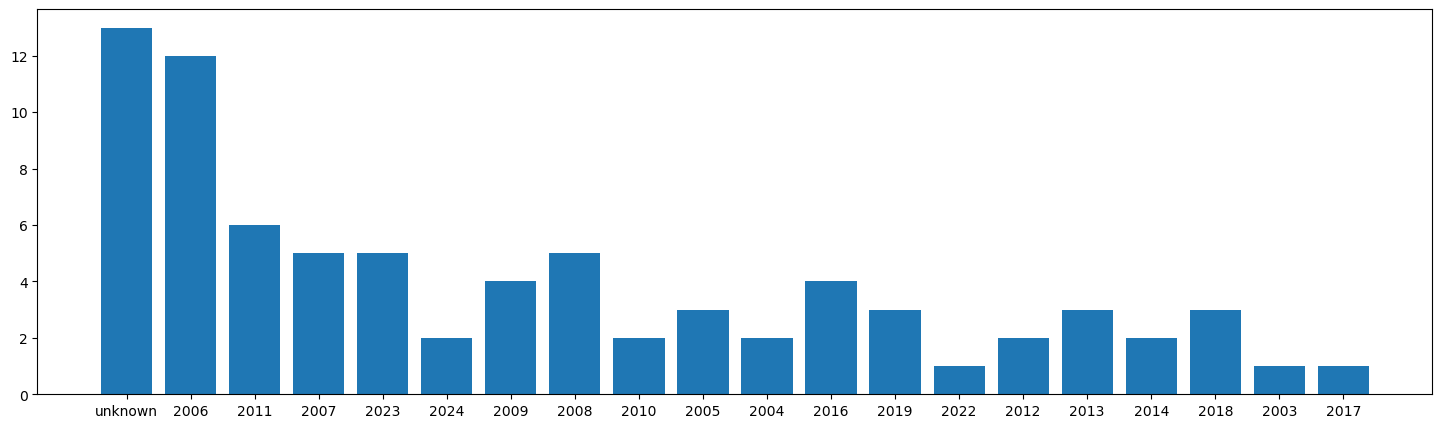

In [63]:
dataframe = getData()

criteriaToColumn = {'year':'dateTaken', 'orientation':'orientation'}
criteria = ''
while criteria not in criteriaToColumn :
    criteria = input('criteria ? (year or orientation):')


categories = ['unknown']
cardinals  = [0]


for i in range(len(dataframe.index)):
    value = str(dataframe._get_value(i, criteriaToColumn[criteria]))

    if value != 'None':
        if criteria == 'year':
            value = value.split(':')[0].strip()
        elif criteria == 'orientation':
            value = {'0':"Portrait", '1':"Landscape"}[value]

        if value in categories:
            cardinals[categories.index(value)] += 1
        else:
            categories.append(value)
            cardinals.append(1)
    else:
        cardinals[0] += 1

f, ax = plt.subplots(figsize =(18,5))
plt.bar(categories, cardinals)

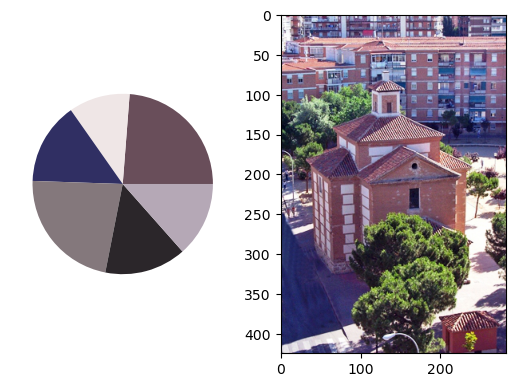

In [64]:
dataframe = getData()

imageIndex = randint(0, len(dataframe['label']))

fig, ax = plt.subplots(1,2)

ax[0].pie(dataframe.at[imageIndex,"dProportions"], colors=(numpy.array(dataframe.at[imageIndex, "dColors"])/255))
ax[1].imshow(PIL.Image.open(dataframe.at[imageIndex, "path"]))


## Application

In [66]:
wTab = ipywidgets.widgets.Tab()
currentUser = 'default'


# UsersWidget
wCurrentUser = ipywidgets.widgets.Dropdown(
    options=getUsers()['name'],
    value='default',
    description='Current User :',
    disabled=False
)
def updateCurrentUser(tmp):
    global currentUser
    currentUser = wCurrentUser.value
wCurrentUser.observe(updateCurrentUser)

def updateUserWidget():
    wCurrentUser.options = getUsers()['name']

# Create User Tab
wUsername = ipywidgets.widgets.Text(
    value='',
    placeholder='',
    description='Username:',
    disabled=False   
)
wBtnCreateUser = ipywidgets.widgets.Button(
    description='Create',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Creates a new user',
    icon='check' # (FontAwesome names without the `fa-` prefix)
)

def createUser(tmp):
    newUser = wUsername.value
    addUser(newUser)
    updateUserWidget()


wBtnCreateUser.on_click(createUser)

wBoxCreateUser = ipywidgets.HBox([wUsername,wBtnCreateUser])

# Random Images Tab
dataframe = getData()
imagePaths = dataframe['path']

wBtnGetRnd = ipywidgets.widgets.Button(description="Get new random Images")
wBtnSelect = ipywidgets.widgets.Button(description="Validate Likes")



rowArray = [wBtnGetRnd]
wCheckArray = []
wImgLayout = ipywidgets.Layout(width = '60%')
cellLayout = ipywidgets.Layout(width = '50%', border = '3px')
def getRandomImages(tmp):
    cellArray = []

    global rowArray
    global wCheckArray

    rowArray = [wBtnGetRnd]
    wCheckArray = []
    rand = randint(6, len(imagePaths))
    for i,path in enumerate(imagePaths[rand-6:rand]):
        with open(path, "rb") as f :
            wImg   = ipywidgets.widgets.Image(value=f.read(), layout = wImgLayout)
            wCheckArray.append(ipywidgets.Checkbox())
            cellArray.append(ipywidgets.HBox([wImg, wCheckArray[-1]], layout = cellLayout))
        if (i+1)%3 == 0:
            rowArray.append(ipywidgets.HBox(cellArray))
            cellArray = []
    rowArray.append(wBtnSelect)
    updateTab(rowArray)

wBtnGetRnd.on_click(getRandomImages)


def get_likes(btn):
    likedImagePaths    = [imagePaths[i] for i, wCheck in enumerate(wCheckArray) if wCheck.value]
    dislikedImagePaths = [path for path in imagePaths if(path not in likedImagePaths)]

    likedImages    = [dataframe.index[dataframe['path'] == path].tolist()[0] for path in likedImagePaths]
    dislikedImages = [dataframe.index[dataframe['path'] == path].tolist()[0] for path in dislikedImagePaths]
    
    
    usersDf = getUsers()
    currentUserIndex = usersDf.index[usersDf['name'] == currentUser].tolist()[0]
    usersDf['likes'][currentUserIndex] = likedImages
    usersDf['dislikes'][currentUserIndex] = dislikedImages
    saveUsers(usersDf)
    print(usersDf)


wBtnSelect.on_click(get_likes)


def updateTab(rowArray):
    wTab.children = [wBoxCreateUser, ipywidgets.VBox(rowArray)]
    wTab.titles   = ['User', 'Random Images']

    return ipywidgets.VBox([wCurrentUser, wTab])


updateTab(rowArray)

